<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/simclr%2Fbigearthnet/notebooks/Segmentation_DFC2020_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: ResNetUnet \\
Data: DFC2020 \\
Pretrained weights: dependent on pretext tasks



### Environment setup

In [1]:
!pip install ssl_remote_sensing@git+https://github.com/AlexanderLontke/ssl-remote-sensing.git@bigearthnet/vae

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AlexanderLontke/ssl-remote-sensing.git (to revision bigearthnet/vae) to /tmp/pip-install-5rhaadzu/ssl-remote-sensing_fa55183796cd48119a23bee727dd59ad
  Running command git clone -q https://github.com/AlexanderLontke/ssl-remote-sensing.git /tmp/pip-install-5rhaadzu/ssl-remote-sensing_fa55183796cd48119a23bee727dd59ad
  Running command git checkout -b bigearthnet/vae --track origin/bigearthnet/vae
  Switched to a new branch 'bigearthnet/vae'
  Branch 'bigearthnet/vae' set up to track remote branch 'bigearthnet/vae' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 800 kB 29.8 MB/s 
     |████████████████████████████████| 111 kB 90.9 MB/s 
     |████████████████████████████████| 20.9 MB 56.0 M

In [2]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from ssl_remote_sensing.data.dfc2020 import DFC2020
from ssl_remote_sensing.downstream_tasks.segmentation.utils import (
    patch_first_conv,
    get_metrics,
    visualize_result,
)
from ssl_remote_sensing.downstream_tasks.segmentation.training import train
from ssl_remote_sensing.downstream_tasks.segmentation.model import ResNetUNet
from ssl_remote_sensing.pretext_tasks.vae.model import VariationalAutoencoder
from ssl_remote_sensing.pretext_tasks.vae.utils import reproducibility
from ssl_remote_sensing.constants import RANDOM_INITIALIZATION
from ssl_remote_sensing.pretext_tasks.utils import (
    load_encoder_checkpoint_from_pretext_model,
)

# from ssl_remote_sensing.models.ResNet18 import resnet18_encoder

/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapContr

In [4]:
# resnet18_encoder(channels = 12)

In [5]:
import rasterio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
from torchmetrics import JaccardIndex
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score
import gdown
import tarfile

/usr/local/lib/python3.8/dist-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [6]:
import wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu").type

In [8]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [9]:
RANDOM_INITIALIZATION

'random'

In [10]:
g_drive_path = "/content/drive/MyDrive/deep_learning_checkpoints"
check_point_paths = os.listdir(g_drive_path)
check_point_paths += [RANDOM_INITIALIZATION]
check_point_paths = [g_drive_path + "/" + x for x in check_point_paths]
check_point_paths

['/content/drive/MyDrive/deep_learning_checkpoints/SimCLR_BEN_ResNet18_adam_bs500-v1.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/vae_bigearthnet.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/bigan_encoder_allChannels_10_epochs.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/random']

In [37]:
check_point_paths = [
    "/content/drive/MyDrive/deep_learning_checkpoints/bigan_encoder_allChannels_10_epochs.ckpt",
    "/content/drive/MyDrive/deep_learning_checkpoints/random",
]

In [38]:
check_point_paths

['/content/drive/MyDrive/deep_learning_checkpoints/bigan_encoder_allChannels_10_epochs.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/random']

In [11]:
# def batch_mean_and_sd(loader):

#     cnt = 0
#     fst_moment = torch.empty(12)
#     snd_moment = torch.empty(12)

#     for images in loader:
#         b, c, h, w = images.shape
#         nb_pixels = b * h * w
#         sum_ = torch.sum(images, dim=[0, 2, 3])
#         sum_of_square = torch.sum(images ** 2,
#                                   dim=[0, 2, 3])
#         fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
#         snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
#         cnt += nb_pixels

#     mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
#     return mean,std

# mean, std = batch_mean_and_sd(train_loader)
# print("mean and std: \n", mean, std)

In [12]:
# check_point_paths = [
# '/content/drive/MyDrive/deep_learning_checkpoints/vae_bigearthnet_128_32epoch.ckpt']

In [13]:
# print(load_encoder_checkpoint_from_pretext_model('/content/drive/MyDrive/deep_learning_checkpoints/random'))

### Hyperparameter setup

In [14]:
# Model Setup
class Hparams:
    def __init__(self):
        self.epochs = 10  # number of training epochs for pretext tasks
        self.seed = 1234  # randomness seed
        self.gradient_accumulation_steps = 1  # gradient accumulation steps
        self.batch_size = 16
        self.lr = 1e-3
        self.weight_decay = 1e-6
        self.optim = "Adam"
        self.cuda = True  # use coda
        self.transform = True
        self.split = False
        self.frozen = True

In [15]:
train_config = Hparams()

In [16]:
reproducibility(train_config)

## Data

In [17]:
dfc2020_path = "/content/drive/MyDrive/dfc2020/dfc_2020.tar.gz"

In [18]:
with tarfile.open(dfc2020_path, mode="r") as tar:
    tar.extractall(path="/content/")

In [19]:
from torch.utils.data import random_split

In [20]:
means = [
    0.1234,
    0.0996,
    0.0902,
    0.0750,
    0.0965,
    0.1628,
    0.1915,
    0.1875,
    0.2088,
    0.0708,
    0.1413,
    0.0873,
]
stds = [
    0.0195,
    0.0260,
    0.0299,
    0.0453,
    0.0472,
    0.0878,
    0.1105,
    0.1125,
    0.1234,
    0.0511,
    0.0943,
    0.0714,
]

In [21]:
# import os
# import rasterio
# import numpy as np
# import glob
# import torch.utils.data as data
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import torch
# import torchvision.transforms as T
# from typing import Union, Callable

# means = [0.1234, 0.0996, 0.0902, 0.0750, 0.0965, 0.1628, 0.1915, 0.1875, 0.2088,
#         0.0708, 0.1413, 0.0873]
# stds = [0.0195, 0.0260, 0.0299, 0.0453, 0.0472, 0.0878, 0.1105, 0.1125, 0.1234,
#         0.0511, 0.0943, 0.0714]

# def get_dfc2020_normalizer():
#     return T.Normalize(mean=means, std=stds)


# class DFC2020(data.Dataset):
#     """PyTorch dataset class for the DFC2020 dataset"""

#     def __init__(
#         self,
#         path,
#         subset="val",
#         no_savanna=False,
#         use_s2hr=False,
#         use_s2mr=False,
#         use_s2lr=False,
#         use_s1=False,
#         transform: Union[Callable, None] = None
#     ):
#         """Initialize the dataset"""

#         # inizialize
#         super(DFC2020, self).__init__()

#         self.transform = transform

#         # make sure parameters are okay
#         if not (use_s2hr or use_s2mr or use_s2lr or use_s1):
#             raise ValueError(
#                 "No input specified, set at least one of "
#                 + "use_[s2hr, s2mr, s2lr, s1] to True!"
#             )
#         self.use_s2hr = use_s2hr
#         self.use_s2mr = use_s2mr
#         self.use_s2lr = use_s2lr
#         self.use_s1 = use_s1
#         assert subset in ["val", "test"]
#         self.no_savanna = no_savanna

#         # provide number of input channels
#         self.n_inputs = get_ninputs(use_s1, use_s2hr, use_s2mr, use_s2lr)

#         # provide index of channel(s) suitable for previewing the input
#         self.display_channels, self.brightness_factor = get_display_channels(
#             use_s2hr, use_s2mr, use_s2lr
#         )

#         # provide number of classes
#         if no_savanna:
#             self.n_classes = max(DFC2020_CLASSES) - 1
#         else:
#             self.n_classes = max(DFC2020_CLASSES)

#         # make sure parent dir exists
#         assert os.path.exists(path)

#         # build list of sample paths
#         if subset == "val":
#             path = os.path.join(path, "ROIs0000_validation", "s2_validation")
#         else:
#             path = os.path.join(path, "ROIs0000_test", "s2_0")
#         s2_locations = glob.glob(os.path.join(path, "*.tif"), recursive=True)
#         self.samples = []
#         for s2_loc in tqdm(s2_locations, desc="[Load]"):
#             s1_loc = s2_loc.replace("_s2_", "_s1_").replace("s2_", "s1_")
#             lc_loc = s2_loc.replace("_dfc_", "_lc_").replace("s2_", "dfc_")
#             self.samples.append(
#                 {
#                     "lc": lc_loc,
#                     "s1": s1_loc,
#                     "s2": s2_loc,
#                     "id": os.path.basename(s2_loc),
#                 }
#             )

#         # sort list of samples
#         self.samples = sorted(self.samples, key=lambda i: i["id"])

#         print("loaded", len(self.samples), "samples from the dfc2020 subset", subset)

#     def __getitem__(self, index):
#         """Get a single example from the dataset"""

#         # get and load sample from index file
#         sample = self.samples[index]
#         sample_loaded = load_sample(
#             sample,
#             self.use_s1,
#             self.use_s2hr,
#             self.use_s2mr,
#             self.use_s2lr,
#             no_savanna=self.no_savanna,
#             igbp=False,
#         )
#         if self.transform:
#             sample_loaded["image"] = self.transform(np.transpose(sample_loaded["image"], (1, 2, 0)))
#             return sample_loaded
#         else:
#             return sample_loaded

#     def __len__(self):
#         """Get number of samples in the dataset"""
#         return len(self.samples)

#     def visualize_observation(self, idx):
#         sample = self.__getitem__(idx)
#         img = sample["image"]
#         label = sample["label"]

#         print(
#             "id:",
#             sample["id"],
#             "\n",
#             "input shape:",
#             img.shape,
#             "\n",
#             "label shape:",
#             label.shape,
#             "\n",
#         )

#         fig, axs = plt.subplots(1, 2, figsize=(10, 6))

#         img_rgb = img[[3, 2, 1], :, :]
#         img_rgb = np.transpose(img_rgb, (1, 2, 0))
#         img_rgb = img_rgb / img_rgb.max()

#         axs[0].imshow(img_rgb)
#         axs[0].set_title("Sentinel-2 RGB")
#         axs[0].axis("off")

#         mask = label.squeeze()

#         axs[1].imshow(mask)
#         axs[1].set_title("Groundtruth Mask")
#         axs[1].axis("off")

#         plt.show()

# # mapping from igbp to dfc2020 classes
# DFC2020_CLASSES = [
#     0,  # class 0 unused in both schemes
#     1,
#     1,
#     1,
#     1,
#     1,
#     2,
#     2,
#     3,  # --> will be masked if no_savanna == True
#     3,  # --> will be masked if no_savanna == True
#     4,
#     5,
#     6,  # 12 --> 6
#     7,  # 13 --> 7
#     6,  # 14 --> 6
#     8,
#     9,
#     10,
# ]

# # indices of sentinel-2 high-/medium-/low-resolution bands
# S2_BANDS_HR = [2, 3, 4, 8]
# S2_BANDS_MR = [5, 6, 7, 9, 12, 13]
# #S2_BANDS_LR = [1, 10, 11]
# # Remove band 10
# S2_BANDS_LR = [1, 10]

# # util function for reading s2 data
# def load_s2(path, use_hr, use_mr, use_lr):
#     bands_selected = []
#     if use_hr:
#         bands_selected = bands_selected + S2_BANDS_HR
#     if use_mr:
#         bands_selected = bands_selected + S2_BANDS_MR
#     if use_lr:
#         bands_selected = bands_selected + S2_BANDS_LR
#     bands_selected = sorted(bands_selected)
#     with rasterio.open(path) as data:
#         s2 = data.read(bands_selected)
#     s2 = s2.astype(np.float32)
#     s2 = np.clip(s2, 0, 10000)
#     s2 /= 10000
#     s2 = s2.astype(np.float32)
#     return s2


# # util function for reading s1 data
# def load_s1(path):
#     with rasterio.open(path) as data:
#         s1 = data.read()
#     s1 = s1.astype(np.float32)
#     s1 = np.nan_to_num(s1)
#     s1 = np.clip(s1, -25, 0)
#     s1 /= 25
#     s1 += 1
#     s1 = s1.astype(np.float32)
#     return s1


# # util function for reading lc data
# def load_lc(path, no_savanna=False, igbp=True):

#     # load labels
#     with rasterio.open(path) as data:
#         lc = data.read(1)

#     # convert IGBP to dfc2020 classes
#     if igbp:
#         lc = np.take(DFC2020_CLASSES, lc)
#     else:
#         lc = lc.astype(np.int64)

#     # adjust class scheme to ignore class savanna
#     if no_savanna:
#         lc[lc == 3] = 0
#         lc[lc > 3] -= 1

#     # convert to zero-based labels and set ignore mask
#     lc -= 1
#     lc[lc == -1] = 255
#     return lc


# # util function for reading data from single sample
# def load_sample(
#     sample,
#     use_s1,
#     use_s2hr,
#     use_s2mr,
#     use_s2lr,
#     no_savanna=False,
#     igbp=True,
#     unlabeled=False,
# ):

#     use_s2 = use_s2hr or use_s2mr or use_s2lr

#     # load s2 data
#     if use_s2:
#         img = load_s2(sample["s2"], use_s2hr, use_s2mr, use_s2lr)

#     # load s1 data
#     if use_s1:
#         if use_s2:
#             img = np.concatenate((img, load_s1(sample["s1"])), axis=0)
#         else:
#             img = load_s1(sample["s1"])

#     # load label
#     if unlabeled:
#         return {"image": img, "id": sample["id"]}
#     else:
#         lc = load_lc(sample["lc"], no_savanna=no_savanna, igbp=igbp)

#         return {"image": img, "label": lc, "id": sample["id"]}


# # util function for reading data from single sample
# def load_sample_visual(
#     sample,
#     use_s1,
#     use_s2hr,
#     use_s2mr,
#     use_s2lr,
#     no_savanna=False,
#     igbp=True,
#     unlabeled=False,
# ):

#     use_s2 = use_s2hr or use_s2mr or use_s2lr

#     # load s2 data
#     if use_s2:
#         img = load_s2(sample["s2"], use_s2hr, use_s2mr, use_s2lr)

#     # load s1 data
#     if use_s1:
#         if use_s2:
#             img = np.concatenate((img, load_s1(sample["s1"])), axis=0)
#         else:
#             img = load_s1(sample["s1"])

#     # load label
#     if unlabeled:
#         return {"image": img, "id": sample["id"]}
#     else:
#         lc = torch.tensor(load_lc(sample["lc"], no_savanna=no_savanna, igbp=igbp))

#         return {"image": img, "label": lc, "id": sample["id"]}


# # calculate number of input channels
# def get_ninputs(use_s1, use_s2hr, use_s2mr, use_s2lr):
#     n_inputs = 0
#     if use_s2hr:
#         n_inputs += len(S2_BANDS_HR)
#     if use_s2mr:
#         n_inputs += len(S2_BANDS_MR)
#     if use_s2lr:
#         n_inputs += len(S2_BANDS_LR)
#     if use_s1:
#         n_inputs += 2
#     return n_inputs


# # select channels for preview images
# def get_display_channels(use_s2hr, use_s2mr, use_s2lr):
#     if use_s2hr and use_s2lr:
#         display_channels = [3, 2, 1]
#         brightness_factor = 3
#     elif use_s2hr:
#         display_channels = [2, 1, 0]
#         brightness_factor = 3
#     elif not (use_s2hr or use_s2mr or use_s2lr):
#         display_channels = 0
#         brightness_factor = 1
#     else:
#         display_channels = 0
#         brightness_factor = 3
#     return (display_channels, brightness_factor)

In [22]:
import torchvision.transforms as transforms

if train_config.transform:

    # transform = transforms.Normalize(mean=means, std=stds)
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                mean=means, std=stds
            ),  # params computed from the eurosat data
        ]
    )
else:
    transform = None

In [23]:
dataset = DFC2020(
    "/content/dfc_data",
    subset="test",
    use_s1=False,
    use_s2lr=True,
    use_s2hr=True,
    use_s2mr=True,
    no_savanna=True,
    transform=transform,
)
trainset, valset = random_split(dataset, [4102, 1026])

[Load]: 100%|██████████| 5128/5128 [00:00<00:00, 440691.53it/s]

loaded 5128 samples from the dfc2020 subset test


id: ROIs0000_test_s2_0_p1106.tif 
 input shape: torch.Size([12, 256, 256]) 
 label shape: (256, 256) 



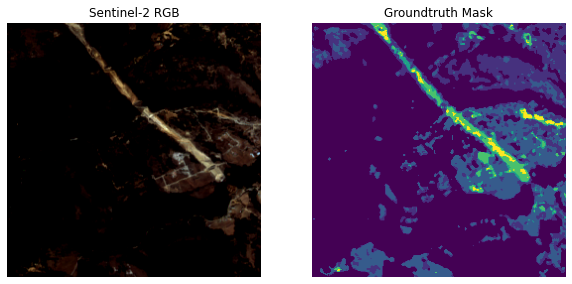

In [24]:
dataset.visualize_observation(121)

In [25]:
train_loader = DataLoader(
    trainset,
    batch_size=32,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    drop_last=False,
)
val_loader = DataLoader(
    valset, batch_size=32, shuffle=True, num_workers=1, pin_memory=True, drop_last=False
)

In [26]:
next(iter(train_loader))["label"].shape

torch.Size([32, 256, 256])

In [39]:
import os
import torch
import torch.nn as nn
import random
import wandb
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ssl_remote_sensing.pretext_tasks.vae.model import VariationalAutoencoder
from ssl_remote_sensing.pretext_tasks.simclr.training import SimCLRTraining
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score
from ssl_remote_sensing.pretext_tasks.simclr.training import SimCLRTraining
from ssl_remote_sensing.models.ResNet18 import ResNetEncoder, resnet18_encoder
from ssl_remote_sensing.pretext_tasks.simclr.config import get_simclr_config
from ssl_remote_sensing.pretext_tasks.vae.config import get_vae_config
from ssl_remote_sensing.pretext_tasks.vae.model import VariationalAutoencoder
from ssl_remote_sensing.pretext_tasks.gan.bigan_encoder import BiganResnetEncoder
from ssl_remote_sensing.models.ResNet18 import resnet18_basenet
from ssl_remote_sensing.pretext_tasks.gan.config import get_bigan_config


def visualize_result(idx, bst_model, valset, device, wandb=wandb, model_name=None):

    if not idx:
        idx = random.randint(0, len(valset))
        print("Validation image ID: {}".format(idx))

    sample = valset.__getitem__(idx)
    img = sample["image"]
    label = sample["label"]

    fig, axs = plt.subplots(1, 3, figsize=(10, 6))

    img_rgb = img[[3, 2, 1], :, :]
    img_rgb = np.transpose(img_rgb, (1, 2, 0))
    img_rgb = img_rgb / img_rgb.max()

    mask = label.squeeze()

    input_img = img.cpu().detach().numpy()
    input_img = torch.from_numpy(input_img)
    input_img = torch.unsqueeze(input_img.float().to(device), 0)
    output = bst_model(input_img)
    output = torch.nn.functional.softmax(output, dim=1)
    output = torch.argmax(output, dim=1)
    output = output.to("cpu").squeeze(0).numpy()

    # # wandb log
    # img_log = wandb.Image(img_rgb, caption="Sentinel-2 RGB")
    # wandb.log({f"Sentinal-2 RGB: {model_name}": img_log})
    # mask_log = wandb.Image(
    #     Image.fromarray(np.uint8(mask)).convert("RGB"), caption="Groundtruth Mask"
    # )
    # wandb.log({f"Groundtruth Mask: {model_name}": mask_log})
    # output_log = wandb.Image(
    #     Image.fromarray(np.uint8(output)).convert("RGB"), caption="Predicted Mask"
    # )
    # wandb.log({f"Predicted Mask: {model_name}": output_log})

    axs[0].imshow(img_rgb)
    axs[0].set_title("Sentinel-2 RGB")
    axs[0].axis("off")

    axs[1].imshow(mask)
    axs[1].set_title("Groundtruth Mask")
    axs[1].axis("off")

    axs[2].imshow(output)
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.show()

## Segmentation Model

In [30]:
loss_fn = nn.CrossEntropyLoss(ignore_index=255, reduction="mean")

train_acc_segmentation,▁▅▆▇▇█████
train_iou_segmentation,▁▅▅▆▇▇████
train_loss_segmentation,█▄▃▂▂▁▁▁▁▁
val_acc_segmentation,▁▄▅▅▇▆▇▇██
val_iou_segmentation,▁▃▅▅▆▆▇▇█▇
val_loss_segmentation,█▅▄▄▂▃▂▂▁▁
train_acc_segmentation,0.85947
train_iou_segmentation,0.53651
train_loss_segmentation,0.37998
val_acc_segmentation,0.86373
val_iou_segmentation,0.53222


Validation Loss: 0.6406: 100%|██████████| 33/33 [00:15<00:00,  2.09it/s]

train_iou is 0.3323, val_iou is 0.3890
train_acc is 0.7102, val_acc is 0.7707



Validation Loss: 0.5597: 100%|██████████| 33/33 [00:15<00:00,  2.09it/s]


Saving Model...
train_iou is 0.4186, val_iou is 0.4218
train_acc is 0.7913, val_acc is 0.8026


Validation Loss: 0.4908: 100%|██████████| 33/33 [00:15<00:00,  2.09it/s]


Saving Model...
train_iou is 0.4510, val_iou is 0.4654
train_acc is 0.8148, val_acc is 0.8276


Validation Loss: 0.4911: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]

train_iou is 0.4797, val_iou is 0.4755
train_acc is 0.8298, val_acc is 0.8277



Validation Loss: 0.4650: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Saving Model...
train_iou is 0.4898, val_iou is 0.4819
train_acc is 0.8364, val_acc is 0.8344


Validation Loss: 0.4362: 100%|██████████| 33/33 [00:15<00:00,  2.09it/s]


Saving Model...
train_iou is 0.4999, val_iou is 0.5016
train_acc is 0.8409, val_acc is 0.8429


Validation Loss: 0.4045: 100%|██████████| 33/33 [00:15<00:00,  2.09it/s]


Saving Model...
train_iou is 0.5129, val_iou is 0.5245
train_acc is 0.8466, val_acc is 0.8543


Validation Loss: 0.4168: 100%|██████████| 33/33 [00:15<00:00,  2.09it/s]

train_iou is 0.5207, val_iou is 0.5281
train_acc is 0.8515, val_acc is 0.8493



Validation Loss: 0.4043: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Saving Model...
train_iou is 0.5274, val_iou is 0.5227
train_acc is 0.8539, val_acc is 0.8530


Validation Loss: 0.3809: 100%|██████████| 33/33 [00:15<00:00,  2.09it/s]


Saving Model...
train_iou is 0.5254, val_iou is 0.5322
train_acc is 0.8534, val_acc is 0.8607
Finished Training


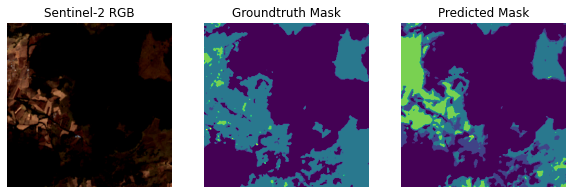

train_acc_segmentation,▁▅▆▇▇▇████
train_iou_segmentation,▁▄▅▆▇▇▇███
train_loss_segmentation,█▄▃▂▂▂▁▁▁▁
val_acc_segmentation,▁▃▅▅▆▇█▇▇█
val_iou_segmentation,▁▃▅▅▆▇████
val_loss_segmentation,█▆▄▄▃▂▂▂▂▁
train_acc_segmentation,0.85344
train_iou_segmentation,0.52541
train_loss_segmentation,0.40087
val_acc_segmentation,0.86068
val_iou_segmentation,0.53222


Validation Loss: 0.5916: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]

train_iou is 0.3372, val_iou is 0.4121
train_acc is 0.7208, val_acc is 0.7923



Validation Loss: 0.5272: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


Saving Model...
train_iou is 0.4300, val_iou is 0.4452
train_acc is 0.8021, val_acc is 0.8114


Validation Loss: 0.4873: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


Saving Model...
train_iou is 0.4629, val_iou is 0.4541
train_acc is 0.8202, val_acc is 0.8263


Validation Loss: 0.4393: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Saving Model...
train_iou is 0.4854, val_iou is 0.4919
train_acc is 0.8339, val_acc is 0.8410


Validation Loss: 0.4088: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Saving Model...
train_iou is 0.5023, val_iou is 0.5190
train_acc is 0.8415, val_acc is 0.8539


Validation Loss: 0.4270: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]

train_iou is 0.5110, val_iou is 0.5145
train_acc is 0.8454, val_acc is 0.8438



Validation Loss: 0.3973: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Saving Model...
train_iou is 0.5162, val_iou is 0.5187
train_acc is 0.8476, val_acc is 0.8546


Validation Loss: 0.3911: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Saving Model...
train_iou is 0.5279, val_iou is 0.5278
train_acc is 0.8535, val_acc is 0.8560


Validation Loss: 0.3939: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]

train_iou is 0.5331, val_iou is 0.5470
train_acc is 0.8556, val_acc is 0.8582



Validation Loss: 0.3679: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Saving Model...
train_iou is 0.5314, val_iou is 0.5538
train_acc is 0.8558, val_acc is 0.8652
Finished Training


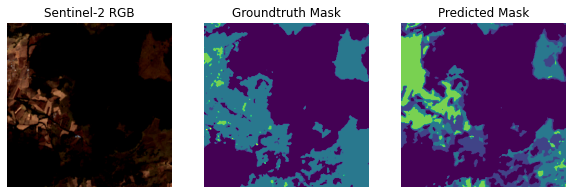

In [40]:
for filename in check_point_paths:
    # Update checkpoint name
    train_config.checkpoint_name = filename
    # Load Encoder from different pre-text architectures
    encoder = load_encoder_checkpoint_from_pretext_model(
        path_to_checkpoint=filename,
    )
    # patch_first_conv(encoder,13,default_in_channels=3)

    # freeze layers
    if train_config.frozen == True:
        for param in encoder.parameters():
            param.requires_grad = False

    model_name = filename.split("/")[-1].split(".")[0]
    model_dir = "/content/drive/My Drive/deep_learning_segmentation_checkpoints"
    model_path = os.path.join(model_dir, f"segmentation_{model_name}_eurosat13.ckpt")
    # make sure the directory path exists
    assert os.path.exists(model_dir)

    wandb.init(
        project="ssl-remote-sensing-segmentation-dfc-frozen-normalize",
        name=model_name,
        config=train_config.__dict__,
    )

    # Model setup
    if "bigan" in train_config.checkpoint_name.lower():
        model = ResNetUNet(9, encoder=encoder, gan_encoder=True)
    else:
        model = ResNetUNet(9, encoder=encoder, gan_encoder=False)

    # train(model)
    train(
        model,
        train_config,
        train_loader,
        val_loader,
        loss_fn,
        device,
        model_path,
        wandb=wandb,
    )

    # Initialise a UNet() model
    if "bigan" in train_config.checkpoint_name.lower():
        bst_model = ResNetUNet(9, encoder=encoder, gan_encoder=True)
    else:
        bst_model = ResNetUNet(9, encoder=encoder, gan_encoder=False)
    # # Load pretrained weights
    bst_model.load_state_dict(torch.load(model_path))
    # # Move to device (GPU or CPU)
    bst_model.to(device)
    # visualize_result(171,bst_model)
    visualize_result(171, bst_model, valset, device, wandb=wandb, model_name=model_name)